In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
from datetime import date
from category_mapper import cat_mapper

np.set_printoptions(suppress=True)



In [21]:
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 51)

In [22]:
# pd.read_csv('Chase_checking_9333_Activity_20240611.CSV')

In [23]:
csv_file_list = []
for i in os.listdir():
    if '.csv' in i.lower():
        csv_file_list.append(i)

In [24]:
def fidelity_credit_cleaner(frame):
    frame = frame.rename(columns={'Name':'Description'})
    frame['Date'] = pd.to_datetime(frame['Date'])
    return frame

In [25]:
def chase_checking_cleaner(frame):
    frame = frame.rename(columns={'Posting Date': 'Date'})
    frame['Date'] = pd.to_datetime(frame['Date'])
    return frame
    

In [26]:
def chase_credit_cleaner(frame):
    frame = frame.drop('Post Date',axis=1)
    frame = frame.drop('Memo', axis=1)
    
    frame = frame.rename(columns={'Transaction Date':'Date'})
    frame['Date'] = pd.to_datetime(frame['Date'])
    # frame['Amount'] = frame['Amount'] * -1
    return frame
    

In [27]:
def amex_credit_cleaner(frame):
    frame['Date'] = pd.to_datetime(frame['Date'])
    frame['Amount'] = frame['Amount'] * -1
    return frame
    

In [28]:
df = pd.DataFrame()
for i in csv_file_list:
    if 'amex' in i.lower():
        temp_df = pd.read_csv(i)
        
        temp_df = amex_credit_cleaner(temp_df)

        temp_df['file_name'] = i.split('.')[0]
        
        df = pd.concat([df, temp_df])
        # print('hello')
    elif ('chase' in i.lower()) & ('credit' in i.lower()):
        temp_df = pd.read_csv(i)
       
        # Transform to fit amex transactions
        temp_df = chase_credit_cleaner(temp_df)

        temp_df['file_name'] = i.split('.')[0]
       
        df = pd.concat([df, temp_df])
    elif ('chase' in i.lower()) & ('checking' in i.lower()):
        temp_df = pd.read_csv(i,index_col=False)
        temp_df = chase_checking_cleaner(temp_df)
        temp_df['file_name'] = i.split('.')[0]

        df = pd.concat([df, temp_df])
    elif ('fidelity' in i.lower()) & ('credit' in i.lower()):
        temp_df = pd.read_csv(i, index_col=False)
        temp_df = fidelity_credit_cleaner(temp_df)
        temp_df['file_name'] = i.split('.')[0]

        df = pd.concat([df, temp_df])

    elif ('clean' in i.lower()):
        temp_df = pd.read_csv(i, index_col=False)
        temp_df['Date'] = pd.to_datetime(temp_df['Date'])
        temp_df = temp_df.drop('Unnamed: 0', axis=1)
        df = pd.concat([df,temp_df])
        

In [29]:
df = df.reset_index(drop=True)

In [30]:
drop_col_list = df.columns[:20].to_list()
df = df.drop_duplicates(subset=drop_col_list)

### Feature creation for Analysis

In [31]:
df['bank'] = df['file_name'].str.split('_').str[0]
df['account_type'] = df['file_name'].str.split('_').str[1]
df['account_number'] = df['file_name'].str.split('_').str[2]

df['month_name'] = df['Date'].dt.month_name()
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year.astype('Int64')
df['month_year'] = df['month_name'].str[:3] + "-" + df['year'].astype('str')

In [32]:
#create conditions to filter results that do no benefit from removing numbers and spaces from the Description column
## default result removes all numbers and extra spaces from the description column

cond = [
    df['Description'].str.contains('amex',case=False),
]

choice = [
    df['Description'],
]

default_cond = df['Description'].str.replace(r'\d+','',regex=True).str.replace(r'\s+'," ", regex=True)

df['clean_description'] = np.select(condlist=cond,choicelist=choice,default=default_cond)



In [33]:
#Sort all transactions then shift by 1 and compare to find recurring transactions

df = df.sort_values(['clean_description', 'year','month','Amount'],ascending=[True,False,False, True])


shift_date = df.shift(-1)['Date'].dt.month.astype('Int8')
date_offset = (df['Date'] - pd.DateOffset(months=1)).dt.month
shift_amount = df.shift(-1)['Amount']

df['is_recurring'] = (shift_date == date_offset) & (df['Amount'] == shift_amount)

In [34]:
#Some transactions Are not getting flagged as recurring with the current conditions for various reasons including Bi-weekly payments, variable amount etc.
##Tag some transactions as always recurring and define specific transactions that should never be flagged as recurring

cond = [
    df['Description'].str.contains('first national bank',case=False),
    df['Description'].str.contains('kids kampus',case=False),
]

choice = [
    1,
    1,
]

default_cond = df['is_recurring']

df['is_recurring'] = np.select(cond, choice, default_cond)

### Cleaning and Data mapping

In [35]:
#Establish baseline for null count analysis

og_null_count = df.isnull().sum()
og_null_count = og_null_count.to_frame('original_null_count')
og_null_count

original_null_count
Date                                            0
Description                                     0
Card Member                                  2724
Account #                                    2724
Amount                                          0
Extended Details                             2724
Appears On Your Statement As                 2724
Address                                      2807
City/State                                   2808
Zip Code                                     2808
Country                                      2806
Reference                                    2724
Category                                     1018
file_name                                       0
Details                                      2836
Type                                          988
Balance                                      2836
Check or Slip #                              3436
Transaction                                  3188
Memo                                         3188
bank                                            0
account_type                                    0
account_number                                  0
clean_description                               0
month_name                                      0
month                                           0
year                                            0
month_year                                      0
is_recurring                                    0

In [36]:
test_df = df.copy()

In [37]:
df = cat_mapper(df, 'Description','Category')

In [38]:
#add null count values after cleaning and calculate percentage change

new_null_count = df.isnull().sum().to_frame('cleaned_null_count')
null_count_df = og_null_count.merge(new_null_count, left_index=True, right_index=True)
null_count_df['percent_null_count_difference'] =round((null_count_df['original_null_count']-null_count_df['cleaned_null_count'])/null_count_df['original_null_count'],2)
null_count_df['percent_null_count_difference'] = null_count_df['percent_null_count_difference'].fillna(0.00)


In [39]:
null_count_df

original_null_count  cleaned_null_count  \
Date                                            0                   0   
Description                                     0                   0   
Card Member                                  2724                2724   
Account #                                    2724                2724   
Amount                                          0                   0   
Extended Details                             2724                2724   
Appears On Your Statement As                 2724                2724   
Address                                      2807                2807   
City/State                                   2808                2808   
Zip Code                                     2808                2808   
Country                                      2806                2806   
Reference                                    2724                2724   
Category                                     1018                 746   
file_name                                       0                   0   
Details                                      2836                2836   
Type                                          988                 988   
Balance                                      2836                2836   
Check or Slip #                              3436                3436   
Transaction                                  3188                3188   
Memo                                         3188                3188   
bank                                            0                   0   
account_type                                    0                   0   
account_number                                  0                   0   
clean_description                               0                   0   
month_name                                      0                   0   
month                                           0                   0   
year                                            0                   0   
month_year                                      0                   0   
is_recurring                                    0                   0   

                              percent_null_count_difference  
Date                                                   0.00  
Description                                            0.00  
Card Member                                            0.00  
Account #                                              0.00  
Amount                                                 0.00  
Extended Details                                       0.00  
Appears On Your Statement As                           0.00  
Address                                                0.00  
City/State                                             0.00  
Zip Code                                               0.00  
Country                                                0.00  
Reference                                              0.00  
Category                                               0.27  
file_name                                              0.00  
Details                                                0.00  
Type                                                   0.00  
Balance                                                0.00  
Check or Slip #                                        0.00  
Transaction                                            0.00  
Memo                                                   0.00  
bank                                                   0.00  
account_type                                           0.00  
account_number                                         0.00  
clean_description                                      0.00  
month_name                                             0.00  
month                                                  0.00  
year                                                   0.00  
month_year                                             0.00  
is_recurring                             

In [40]:
df = df.sort_values('Date', ascending=False)

In [41]:
# df[df['Description'].str.contains('|'.join(retailer_aliases['amazon']),regex=True,case=False)]

# s[s.str.contains('|'.join(searchfor))]

In [42]:
# df[df['Description'].str.contains('prime', case=False)]

In [43]:
# df[(df['Description'].str.contains('amazon|amzn', case=False, regex=True)) & (df['Category'].notnull())][:40]

In [44]:
    category_retailers = {'Online Shopping':['amazon','amzn mktp', 'target.com'],
                          'Wholesale Stores': ['costco', 'target'],
                          'Pet Stores':['krisers'],
                          'House Maintenance' : ['cleaning authority'],
                          'Pet Care' : ['lucky dog daycare'],
                          'Taxes' : ['dupage co tax'],
                          'Utilities':['nicor gas'],
                          'Kids: Daycare':['kids kampus'],
                          }

In [45]:
test_df.isnull().sum()

Date                               0
Description                        0
Card Member                     2724
Account #                       2724
Amount                             0
Extended Details                2724
Appears On Your Statement As    2724
Address                         2807
City/State                      2808
Zip Code                        2808
Country                         2806
Reference                       2724
Category                        1018
file_name                          0
Details                         2836
Type                             988
Balance                         2836
Check or Slip #                 3436
Transaction                     3188
Memo                            3188
bank                               0
account_type                       0
account_number                     0
clean_description                  0
month_name                         0
month                              0
year                               0
m

In [57]:
test_df.iloc[0]['Description']

'73209 - 333 NORTH GREEN'

In [54]:
for i,x in enumerate(test_df.index):
    print(test_df.iloc[i])

Date                                            2022-09-30 00:00:00
Description                                 73209 - 333 NORTH GREEN
Card Member                                                     NaN
Account #                                                       NaN
Amount                                                         -9.0
Extended Details                                                NaN
Appears On Your Statement As                                    NaN
Address                                                         NaN
City/State                                                      NaN
Zip Code                                                        NaN
Country                                                         NaN
Reference                                                       NaN
Category                                                     Travel
file_name                       Chase_credit_3326_20220611_20240611
Details                                         

In [61]:
for key,vals in category_retailers.items():
    for i,x in enumerate(test_df.index):
        if test_df.iloc[i]['Description'].lower() in vals:
            test_df.iloc[i]['Category'] = key
        else:
            pass
        # frame[targ_col].str.contains('|'.join(category_retailers['Online Shopping']),regex=True,case=False),

In [63]:
test_df.isnull().sum()

Date                               0
Description                        0
Card Member                     2724
Account #                       2724
Amount                             0
Extended Details                2724
Appears On Your Statement As    2724
Address                         2807
City/State                      2808
Zip Code                        2808
Country                         2806
Reference                       2724
Category                        1018
file_name                          0
Details                         2836
Type                             988
Balance                         2836
Check or Slip #                 3436
Transaction                     3188
Memo                            3188
bank                               0
account_type                       0
account_number                     0
clean_description                  0
month_name                         0
month                              0
year                               0
m

In [27]:
targ_string = 'Kampus'

df[df['Description'].str.contains(targ_string,case=False) ]

Date                                        Description  \
733  2024-06-03  KIDS KAMPUS CHIL 6305770046                 PP...   
745  2024-05-20  KIDS KAMPUS CHIL 6305770046                 PP...   
754  2024-05-06  KIDS KAMPUS CHIL 6305770046                 PP...   
769  2024-04-22  KIDS KAMPUS CHIL 6305770046                 PP...   
775  2024-04-08  KIDS KAMPUS CHIL 6305770046                 PP...   
...         ...                                                ...   
1286 2022-08-15  KIDS KAMPUS INC  6305770046                 PP...   
1298 2022-08-01  KIDS KAMPUS INC  6305770046                 PP...   
1311 2022-07-18  KIDS KAMPUS INC  6305770046                 PP...   
1321 2022-07-05  KIDS KAMPUS INC  6305770046                 PP...   
1335 2022-06-21  KIDS KAMPUS INC  6305770046                 PP...   

     Card Member  Account #  Amount Extended Details  \
733          NaN        NaN -1595.0              NaN   
745          NaN        NaN -1595.0              NaN   
754          NaN        NaN -1595.0              NaN   
769          NaN        NaN -1595.0              NaN   
775          NaN        NaN -1557.5              NaN   
...          ...        ...     ...              ...   
1286         NaN        NaN  -528.0              NaN   
1298         NaN        NaN  -840.0              NaN   
1311         NaN        NaN  -840.0              NaN   
1321         NaN        NaN  -840.0              NaN   
1335         NaN        NaN  -840.0              NaN   

     Appears On Your Statement As Address City/State Zip Code Country  \
733                           NaN     NaN        NaN      NaN     NaN   
745                           NaN     NaN        NaN      NaN     NaN   
754                           NaN     NaN        NaN      NaN     NaN   
769                           NaN     NaN        NaN      NaN     NaN   
775                           NaN     NaN        NaN      NaN     NaN   
...                           ...     ...        ...      ...     ...   
1286                          NaN     NaN        NaN      NaN     NaN   
1298                          NaN     NaN        NaN      NaN     NaN   
1311                          NaN     NaN        NaN      NaN     NaN   
1321                          NaN     NaN        NaN      NaN     NaN   
1335                          NaN     NaN        NaN      NaN     NaN   

     Reference Category                              file_name Details  \
733        NaN      NaN  Chase_checking_9333_Activity_20240611   DEBIT   
745        NaN      NaN  Chase_checking_9333_Activity_20240611   DEBIT   
754        NaN      NaN  Chase_checking_9333_Activity_20240611   DEBIT   
769        NaN      NaN  Chase_checking_9333_Activity_20240611   DEBIT   
775        NaN      NaN  Chase_checking_9333_Activity_20240611   DEBIT   
...        ...      ...                                    ...     ...   
1286       NaN      NaN  Chase_checking_9333_Activity_20240611   DEBIT   
1298       NaN      NaN  Chase_checking_9333_Activity_20240611   DEBIT   
1311       NaN      NaN  Chase_checking_9333_Activity_20240611   DEBIT   
1321       NaN      NaN  Chase_checking_9333_Activity_20240611   DEBIT   
1335       NaN      NaN  Chase_checking_9333_Activity_20240611   DEBIT   

           Type   Balance  Check or Slip # Transaction Memo   bank  \
733   ACH_DEBIT  11635.31              NaN         NaN  NaN  Chase   
745   ACH_DEBIT  15996.72              NaN         NaN  NaN  Chase   
754   ACH_DEBIT  18185.59              NaN         NaN  NaN  Chase   
769   ACH_DEBIT   8381.39              NaN         NaN  NaN  Chase   
775   ACH_DEBIT   8181.59              NaN         NaN  NaN  Chase   
...         ...       ...              ...         ...  ...    ...   
1286  ACH_DEBIT   6172.70              NaN         NaN  NaN  Chase   
1298  ACH_DEBIT   8432.73              NaN         NaN  NaN  Chase   
1311  ACH_DEBIT   7632.01              NaN         NaN  NaN  Chase   
1321  ACH_DEBIT  16458.42      

In [25]:
df[df['Category'].isnull()][:40]

Date                                        Description  \
1345 2024-06-07                            Payment Thank You - Web   
726  2024-06-07         Payment to Chase card ending in 3326 06/07   
727  2024-06-05  AMERICAN EXPRESS ACH PMT    W6670           WE...   
625  2024-06-05                         ONLINE PAYMENT - THANK YOU   
3229 2024-06-05                                PAYMENT   THANK YOU   
728  2024-06-04  DISCOVER BANK    PREARRANGE                 PP...   
731  2024-06-03  Nicor Gas        GAS PAYMNT 7839630782      WE...   
732  2024-06-03  AMEX EPAYMENT    ACH PMT    A9938           WE...   
3240 2024-06-03            FSP*BOUNCE HOUSES R US 630-903-6800  IL   
730  2024-06-03  AMERICAN EXPRESS ACH PMT    M2434           WE...   
3239 2024-06-03            URBAN AIR ADVENTURE PA 817-778-0339  TX   
733  2024-06-03  KIDS KAMPUS CHIL 6305770046                 PP...   
293  2024-06-01                         MOBILE PAYMENT - THANK YOU   
734  2024-05-31  Zelle payment to J&B Landscape Solutions Inc. ...   
736  2024-05-31  WELLMORE HOLDING DIRECT DEP                 PP...   
3262 2024-05-31            TST* SPARROW COFFEE NA Naperville    IL   
735  2024-05-31  APPLECARD GSBANK PAYMENT    19314999        WE...   
3271 2024-05-30            BINNYS BEVERAGE DEPOT  NILES         IL   
3275 2024-05-30            BINNYS BEVERAGE DEPOT  NILES         IL   
737  2024-05-30  THRIVEPASS       REIMBURSE                  PP...   
3268 2024-05-30            BARBER HAUS            SHOPS.GETSQUI NY   
741  2024-05-28  AMEX EPAYMENT    ACH PMT    A0624           WE...   
740  2024-05-28  VOLVO CAR FIN    AUTO FINAN 1534344         WE...   
3299 2024-05-28            EVERWASH 215-618-8808  HTTPSEVERWASH PA   
739  2024-05-28  AMEX EPAYMENT    ACH PMT    A5042           WE...   
742  2024-05-28  AMEX EPAYMENT    ACH PMT    A0594           WE...   
294  2024-05-28                        AUTOPAY PAYMENT - THANK YOU   
738  2024-05-28  AMERICAN EXPRESS ACH PMT    A4968           WE...   
743  2024-05-23  Online Payment 20560731740 To First National B...   
3332 2024-05-20            COURSERA.ORG           HTTPSWWW.COUR CA   
745  2024-05-20  KIDS KAMPUS CHIL 6305770046                 PP...   
744  2024-05-20  DISCOVER BANK    PREARRANGE                 PP...   
3328 2024-05-20            GROUND EFFECTS SUPPLY  630-5536195   IL   
3330 2024-05-20            THE GROWING PLACE   NA NAPERVILLE    IL   
746  2024-05-17  WELLMORE HOLDING DIRECT DEP                 PP...   
3349 2024-05-17            MENARDS NAPERVILLE IL  NAPERVILLE    IL   
3345 2024-05-17            BUIKEMA S ACE HARDWARE NAPERVILLE    IL   
3340 2024-05-17            BUIKEMA S ACE HARDWARE NAPERVILLE    IL   
3350 2024-05-17            BUIKEMA S ACE HARDWARE NAPERVILLE    IL   
747  2024-05-14  Zelle payment to J&B Landscape Solutions Inc. ...   

        Card Member  Account #   Amount             Extended Details  \
1345            NaN        NaN  2000.00                          NaN   
726             NaN        NaN -2000.00                          NaN   
727             NaN        NaN  -739.04                          NaN   
625   BRUCE LOMBARD   -71004.0   739.04   ONLINE PAYMENT - THANK YOU   
3229            NaN        NaN   123.00                          NaN   
728             NaN        NaN  6000.00                          NaN   
731             NaN        NaN   -45.71                          NaN   
732             NaN        NaN  -645.25                          NaN   
3240            NaN        NaN  -428.55                          NaN   
730             NaN        NaN   -32.70                          NaN   
3239            NaN        NaN   -39.32                          NaN   
733             NaN        NaN -1595.00                          NaN   
293   BRUCE LOMBARD   -91002.0    32.70   MOBILE PAYMENT - THANK YOU   
734             NaN        NaN  -267.00                          NaN   
736             NaN        NaN  6168.42                     

In [93]:
max_date = str((df['Date'].dt.date.max()))
min_date = str((df['Date'].dt.date.min()))


file_name = "clean_" + min_date + "_"  + max_date
print(file_name)

clean_2022-06-11_2024-06-11


In [94]:
df.to_csv(file_name+'.csv')

PermissionError: [Errno 13] Permission denied: 'clean_2022-06-11_2024-06-11.csv'

### Analyze the recurring transactions

In [95]:
df[df['is_recurring'] == True]

Date                                        Description  \
3216 2024-06-07            KRISERS NAPERVILLE     NAPERVILLE    IL   
3215 2024-06-07            THE CLEANING AUTHORITY 847-302-3909  IL   
2856 2024-06-04                            FOREIGN TRANSACTION FEE   
3232 2024-06-04            AMZ*Protea Nutrition   pay.amazon.co SD   
733  2024-06-03  KIDS KAMPUS CHIL 6305770046                 PP...   
...         ...                                                ...   
1315 2022-07-08  GLANBIA PERFORMA DIRECT DEP                 PP...   
3173 2022-07-05                              STAX   *AKITA SECURIT   
1321 2022-07-05  KIDS KAMPUS INC  6305770046                 PP...   
1330 2022-06-24  Online Payment 14412690514 To First National B...   
1335 2022-06-21  KIDS KAMPUS INC  6305770046                 PP...   

     Card Member  Account #   Amount Extended Details  \
3216         NaN        NaN  -101.26              NaN   
3215         NaN        NaN  -229.00              NaN   
2856         NaN        NaN    -0.25              NaN   
3232         NaN        NaN   -57.30              NaN   
733          NaN        NaN -1595.00              NaN   
...          ...        ...      ...              ...   
1315         NaN        NaN  5544.97              NaN   
3173         NaN        NaN   -45.39              NaN   
1321         NaN        NaN  -840.00              NaN   
1330         NaN        NaN -5582.38              NaN   
1335         NaN        NaN  -840.00              NaN   

     Appears On Your Statement As Address City/State Zip Code Country  \
3216                          NaN     NaN        NaN      NaN     NaN   
3215                          NaN     NaN        NaN      NaN     NaN   
2856                          NaN     NaN        NaN      NaN     NaN   
3232                          NaN     NaN        NaN      NaN     NaN   
733                           NaN     NaN        NaN      NaN     NaN   
...                           ...     ...        ...      ...     ...   
1315                          NaN     NaN        NaN      NaN     NaN   
3173                          NaN     NaN        NaN      NaN     NaN   
1321                          NaN     NaN        NaN      NaN     NaN   
1330                          NaN     NaN        NaN      NaN     NaN   
1335                          NaN     NaN        NaN      NaN     NaN   

     Reference               Category                              file_name  \
3216       NaN                    NaN                   fidelity_credit_1925   
3215       NaN                    NaN                   fidelity_credit_1925   
2856       NaN     Fees & Adjustments    Chase_credit_4649_20220611_20240611   
3232       NaN                    NaN                   fidelity_credit_1925   
733        NaN                    NaN  Chase_checking_9333_Activity_20240611   
...        ...                    ...                                    ...   
1315       NaN                    NaN  Chase_checking_9333_Activity_20240611   
3173       NaN  Professional Services    Chase_credit_4649_20220611_20240611   
1321       NaN                    NaN  Chase_checking_9333_Activity_20240611   
1330       NaN                    NaN  Chase_checking_9333_Activity_20240611   
1335       NaN                    NaN  Chase_checking_9333_Activity_20240611   

     Details        Type   Balance  Check or Slip # Transaction  \
3216     NaN         NaN       NaN              NaN       DEBIT   
3215     NaN         NaN       NaN              NaN       DEBIT   
2856     NaN         Fee       NaN              NaN         NaN   
3232     NaN         NaN       NaN              NaN       DEBIT   
733    DEBIT   ACH_DEBIT  11635.31              NaN         NaN   
...      ...         ...       ...              ...         ...   
1315  CREDIT  ACH_CREDIT  14360.70              NaN         NaN   
3173     NaN        Sale       NaN              NaN         NaN   
1321   DEBIT   ACH_DEBIT  16458.42          

In [76]:
df

Date                                 Description    Card Member  \
0    2022-12-29                  MOBILE PAYMENT - THANK YOU  BRUCE LOMBARD   
1    2022-12-21                    THE DISNEY BUNDLE CREDIT  BRUCE LOMBARD   
2    2022-12-17  1707 S WASHINGTON STNAPERVILLE          IL  BRUCE LOMBARD   
3    2022-12-17  JEWEL OSCO 1111 1111NAPERVILLE          IL  BRUCE LOMBARD   
4    2022-12-17  WHOLEFDS NPV 10129 0NAPERVILLE          IL  BRUCE LOMBARD   
...         ...                                         ...            ...   
3912 2024-01-25     VOLVO OF LISLE         LISLE         IL            NaN   
3914 2024-01-24     AMZN Mktp US*R85620RN2 Amzn.com/bill WA            NaN   
3916 2024-01-23     SIF CAR CARE LLC       NAPERVILLE    IL            NaN   
3918 2024-01-22     COSTCO WHSE#1443       NAPERVILLE    IL            NaN   
3919 2024-01-22     COSTCO WHSE#1443       NAPERVILLE    IL            NaN   

      Account #   Amount                                   Extended Details  \
0      -91002.0  2673.40                         MOBILE PAYMENT - THANK YOU   
1      -91002.0     7.00                           THE DISNEY BUNDLE CREDIT   
2      -91002.0   -49.49  00000004401 6303550157\r\n1707 S WASHINGTON ST...   
3      -91002.0   -35.92  0124137     800-898-4027\r\nJEWEL OSCO 1111 11...   
4      -91002.0   -90.91  0C2LHY492MF 6305797700\r\nWHOLEFDS NPV 10129 0...   
...         ...      ...                                                ...   
3912        NaN   -41.39                                                NaN   
3914        NaN   -64.64                                                NaN   
3916        NaN   -15.00                                                NaN   
3918        NaN    -3.79                                                NaN   
3919        NaN  -266.64                                                NaN   

                    Appears On Your Statement As                Address  \
0                     MOBILE PAYMENT - THANK YOU                    NaN   
1                       THE DISNEY BUNDLE CREDIT          2500 BROADWAY   
2     1707 S WASHINGTON STNAPERVILLE          IL  12700 NORTHBOROUGH DR   
3     JEWEL OSCO 1111 1111NAPERVILLE          IL        1227 NAPER BLVD   
4     WHOLEFDS NPV 10129 0NAPERVILLE          IL      2607 WEST 75TH ST   
...                                          ...                    ...   
3912                                         NaN                    NaN   
3914                                         NaN                    NaN   
3916                                         NaN                    NaN   
3918                                         NaN                    NaN   
3919                                         NaN                    NaN   

              City/State    Zip Code        Country             Reference  \
0                    NaN         NaN            NaN  '320223630765283073'   
1     SANTA MONICA\r\nCA  90404-3065  UNITED STATES  '320223550614393280'   
2          HOUSTON\r\nTX  77067-2552  UNITED STATES  '320223520535625915'   
3       NAPERVILLE\r\nIL       60540  UNITED STATES  '320223520526343876'   
4       NAPERVILLE\r\nIL       60540  UNITED STATES  '320223520532548570'   
...                  ...         ...            ...                   ...   
3912                 NaN         NaN            NaN                   NaN   
3914                 NaN         NaN            NaN                   NaN   
3916                 NaN         NaN            NaN                   NaN   
3918                 NaN         NaN            NaN                   NaN   
3919                 NaN         NaN            NaN                   NaN   

                                  Category                  file_name Details  \
0                                      NaN  amex_credit_1002_bce_2022     NaN   
1     Communications-Cable & Internet Comm  amex_credit_1002_bce_2022     NaN   
2                      Transportation-Fuel  amex_credit_

In [96]:
recur = df[df['is_recurring'] == True]

In [97]:
# recur2 = 
# recur['adjusted_amount'] = np.where(recur['account_type']=='credit',recur['Amount']*-1,recur['Amount'])

In [98]:
recur = recur.sort_values('Date')

In [99]:
# recur_group = recur.groupby('month_year',as_index=False,sort=False)['adjusted_amount'].sum()
recur_group = recur.groupby('month_year',as_index=False,sort=False)['Amount'].sum()

In [100]:
recur_group['Amount'] = recur_group['Amount']*-1

In [101]:
recur_group

month_year    Amount
0    Jun-2022   6422.38
1    Jul-2022   3364.30
2    Aug-2022   9007.10
3    Sep-2022   8396.43
4    Oct-2022   8833.45
5    Nov-2022   8361.46
6    Dec-2022   2952.32
7    Jan-2023   9379.67
8    Feb-2023   3257.54
9    Mar-2023   8250.45
10   Apr-2023   9072.15
11   May-2023   8500.73
12   Jun-2023   2132.24
13   Jul-2023   7715.85
14   Aug-2023   7076.52
15   Sep-2023   8655.94
16   Oct-2023   8819.34
17   Nov-2023   9051.88
18   Dec-2023   9544.27
19   Jan-2024   9700.76
20   Feb-2024  10766.16
21   Mar-2024   9484.20
22   Apr-2024  10074.93
23   May-2024  10805.69
24   Jun-2024   1982.81

In [102]:
recur.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381 entries, 1335 to 3216
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          381 non-null    datetime64[ns]
 1   Description                   381 non-null    object        
 2   Card Member                   38 non-null     object        
 3   Account #                     38 non-null     float64       
 4   Amount                        381 non-null    float64       
 5   Extended Details              38 non-null     object        
 6   Appears On Your Statement As  38 non-null     object        
 7   Address                       34 non-null     object        
 8   City/State                    34 non-null     object        
 9   Zip Code                      34 non-null     object        
 10  Country                       34 non-null     object        
 11  Reference                     38 

In [103]:
recur[recur['month_year'] == 'May-2024']

Date                                        Description  \
659  2024-05-03         TST* SPARROW COFFEE NAPERVILLE          IL   
3433 2024-05-03            THE CLEANING AUTHORITY 847-302-3909  IL   
2863 2024-05-05                            FOREIGN TRANSACTION FEE   
2014 2024-05-06                                Akita Security Inc.   
1380 2024-05-06                            LinkedIn Pre 9530668406   
3417 2024-05-06            AMZ*Protea Nutrition   pay.amazon.co SD   
754  2024-05-06  KIDS KAMPUS CHIL 6305770046                 PP...   
2012 2024-05-07                                   WWW.HIBOBBIE.COM   
2010 2024-05-09                                     SP HIYA HEALTH   
296  2024-05-16         HULU 877-8244858 CA HULU.COM/BILL       CA   
1368 2024-05-17                                    GLO NAIL LOUNGE   
1366 2024-05-18                          TST* SPARROW COFFEE NAPER   
2861 2024-05-19                                   The Roku Channel   
295  2024-05-20                           $84 Disney Bundle Credit   
744  2024-05-20  DISCOVER BANK    PREARRANGE                 PP...   
745  2024-05-20  KIDS KAMPUS CHIL 6305770046                 PP...   
3332 2024-05-20            COURSERA.ORG           HTTPSWWW.COUR CA   
1364 2024-05-20                                RITUAL (RITUAL.COM)   
743  2024-05-23  Online Payment 20560731740 To First National B...   
2859 2024-05-28                                  DollarShaveClubUS   
3299 2024-05-28            EVERWASH 215-618-8808  HTTPSEVERWASH PA   
2860 2024-05-28                                        COOPERSHAWK   
740  2024-05-28  VOLVO CAR FIN    AUTO FINAN 1534344         WE...   
737  2024-05-30  THRIVEPASS       REIMBURSE                  PP...   
2858 2024-05-30                                    COMCAST CHICAGO   
1351 2024-05-31                                           SHRED415   

        Card Member  Account #   Amount  \
659   BRUCE LOMBARD   -71004.0   -15.85   
3433            NaN        NaN  -229.00   
2863            NaN        NaN    -0.25   
2014            NaN        NaN   -45.39   
1380            NaN        NaN   -69.99   
3417            NaN        NaN   -57.30   
754             NaN        NaN -1595.00   
2012            NaN        NaN  -274.55   
2010            NaN        NaN   -37.71   
296   BRUCE LOMBARD   -91002.0   -24.99   
1368            NaN        NaN   -65.00   
1366            NaN        NaN   -14.35   
2861            NaN        NaN    -5.99   
295   BRUCE LOMBARD   -91002.0     7.00   
744             NaN        NaN  -514.29   
745             NaN        NaN -1595.00   
3332            NaN        NaN   -49.00   
1364            NaN        NaN   -33.58   
743             NaN        NaN -5200.00   
2859            NaN        NaN   -12.96   
3299            NaN        NaN   -35.00   
2860            NaN        NaN   -44.99   
740             NaN        NaN  -665.00   
737             NaN        NaN    62.50   
2858            NaN        NaN  -121.00   
1351            NaN        NaN  -169.00   

                                       Extended Details  \
659   21105174125 312-648-6415\r\nTST* SPARROW COFFE...   
3433                                                NaN   
2863                                                NaN   
2014                                                NaN   
1380                                                NaN   
3417                                                NaN   
754                                                 NaN   
2012                                                NaN   
2010                                                NaN   
296   427814995:7 HULU.COM/BILL\r\nHULU 877-8244858 ...   
1368                                                NaN   
1366                                                NaN   
2861                                                NaN   
295                            $84 Disney Bundle Credit   
744                                                 NaN   
745           

In [104]:
recur_group

month_year    Amount
0    Jun-2022   6422.38
1    Jul-2022   3364.30
2    Aug-2022   9007.10
3    Sep-2022   8396.43
4    Oct-2022   8833.45
5    Nov-2022   8361.46
6    Dec-2022   2952.32
7    Jan-2023   9379.67
8    Feb-2023   3257.54
9    Mar-2023   8250.45
10   Apr-2023   9072.15
11   May-2023   8500.73
12   Jun-2023   2132.24
13   Jul-2023   7715.85
14   Aug-2023   7076.52
15   Sep-2023   8655.94
16   Oct-2023   8819.34
17   Nov-2023   9051.88
18   Dec-2023   9544.27
19   Jan-2024   9700.76
20   Feb-2024  10766.16
21   Mar-2024   9484.20
22   Apr-2024  10074.93
23   May-2024  10805.69
24   Jun-2024   1982.81

C:\Users\blomb\AppData\Local\Temp\ipykernel_1608\2725235881.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(recur_group, x='month_year', y='Amount',palette='viridis')


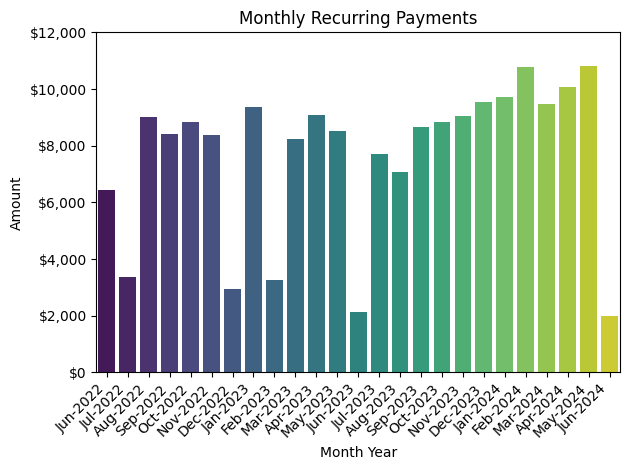

In [121]:

# plt.figure(figsize=(8,6), dpi=200)
g = sns.barplot(recur_group, x='month_year', y='Amount',palette='viridis')
plt.xticks(rotation=45, horizontalalignment='right')
plt.yticks(ticks =[x for x in g.get_yticks()],labels=['${:,.0f}'.format(x) for x in g.get_yticks()])
plt.xlabel('Month Year')
plt.ylabel('Amount')
plt.title('Monthly Recurring Payments')
plt.tight_layout()



plt.show()